In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import ks_2samp
from scipy import stats
from sklearn.svm import OneClassSVM
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [17]:

def read_error_csv(path):

    if os.path.exists(path):
        df = pd.read_csv(path)
        return df
    return None

In [18]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [19]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]
epilepsy_irm_neg= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_negatives_centrales"]
epilepsy_irm_pos= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_positives_centrales"]

In [20]:
def separate_epilepsy_PBS(Embeddings): #To separate the Embeddings into controls, irm_neg and irm_pos
    Embeddings = Embeddings.rename(columns={Embeddings.columns[0]: "Index"})

    Embeddings_control = Embeddings.merge(epilepsy_controls[["Index"]], on="Index", how="inner")
    Embeddings_neg =Embeddings.merge(epilepsy_irm_neg[["Index"]], on="Index", how="inner")
    Embeddings_pos = Embeddings.merge(epilepsy_irm_pos[["Index"]], on="Index", how="inner")

    return Embeddings_control, Embeddings_neg, Embeddings_pos

In [21]:
def remove_first_column(Embeddings):
    X= Embeddings.iloc[:,1:76]
    return X

In [22]:
def Normalisation(X1, X2, X3, X4, X5):
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X1)
    X2=scaler.transform(X2)
    X3=scaler.transform(X3)
    X4=scaler.transform(X4)
    X5=scaler.transform(X5)
    return X1, X2, X3, X4, X5

In [23]:
def Residualisation(X1, X2, X3, X4, X5):
    L= np.concatenate((X1,X2,X3,X4,X5), axis=0)

    covariates = pd.DataFrame({
    'Site': ['UKB']*len(X1) 
            + ['hcp']*len(X2) 
            + ['epilepsy_PBS']*(len(X3)+len(X4)+len(X5)) 
})
    covariates = pd.get_dummies(covariates)

    covariates_train= covariates.head(len(X1)+len(X2)+len(X3))

    covariates_test= covariates.iloc[len(X1)+len(X2)+len(X3):len(X1)+len(X2)+len(X3)+len(X4)+len(X5)]

    L_train=np.concatenate((X1,X2,X3), axis=0)
    L_test= np.concatenate((X4,X5), axis=0)

    covariates = sm.add_constant(covariates)

    L1_resid = np.zeros_like(L_train)
    L2_resid = np.zeros_like(L_test)

    for j in range(L_train.shape[1]):
        model = sm.OLS(L_train[:, j].astype(float), covariates_train.astype(float)).fit()
        L1_resid[:, j] = model.resid 
        L2_resid[:, j] = L_test[:,j] - model.predict(covariates_test)

    X_ukb = L1_resid[:len(X1),:]
    X_hcp = L1_resid[len(X1):len(X1)+len(X2),:]
    X_control= L1_resid[len(X1)+len(X2):len(X1)+len(X2)+len(X3),:]
    X_neg= L2_resid[:len(X4),:]
    X_pos=L2_resid[len(X4):,:]

    return X_ukb, X_hcp, X_control, X_neg, X_pos

In [24]:
def UMAP_2D(X1, X2, X3, X4, X5):
    reducer = umap.UMAP(n_components=2, random_state=42)
    X1_umap = reducer.fit_transform(X1)
    X2_umap = reducer.transform(X2)
    X3_umap= reducer.transform(X3)
    X4_umap=reducer.transform(X4)
    X5_umap=reducer.transform(X5)
    return X1_umap, X2_umap, X3_umap, X4_umap, X5_umap

In [25]:
def proportion_positive(L):
    n_total = len(L)
    n_pos = np.sum(L == 1)

    return n_pos / n_total

In [26]:
dir_path= "/neurospin/tmp/fred/models/2025-11-10" 

In [27]:
def PLOT(ax, nu, prop_positive_UKB, prop_positive_hcp, prop_positive_control, prop_positive_neg, prop_positive_pos):
    ax.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
    ax.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
    ax.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
    ax.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="irm_neg")
    ax.plot(nu, prop_positive_pos, marker='o', linestyle='-', label="irm_pos")


In [28]:
def Calcul(nu, X1, X2, X3, X4, X5):
    prop_positive_UKB= []
    prop_positive_hcp= []
    prop_positive_control= []
    prop_positive_neg= []
    prop_positive_pos= []

    for u in nu:

        clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
        clf.fit(X1)
        y1 = clf.predict(X1)
        y2 = clf.predict(X2)
        y3 = clf.predict(X3)
        y4 = clf.predict(X4)
        y5 = clf.predict(X5)

        prop_positive_UKB.append(proportion_positive(y1))
        prop_positive_hcp.append(proportion_positive(y2))
        prop_positive_control.append(proportion_positive(y3))
        prop_positive_neg.append(proportion_positive(y4))
        prop_positive_pos.append(proportion_positive(y5))
    return prop_positive_UKB, prop_positive_hcp, prop_positive_control, prop_positive_neg, prop_positive_pos

In [29]:
import re

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


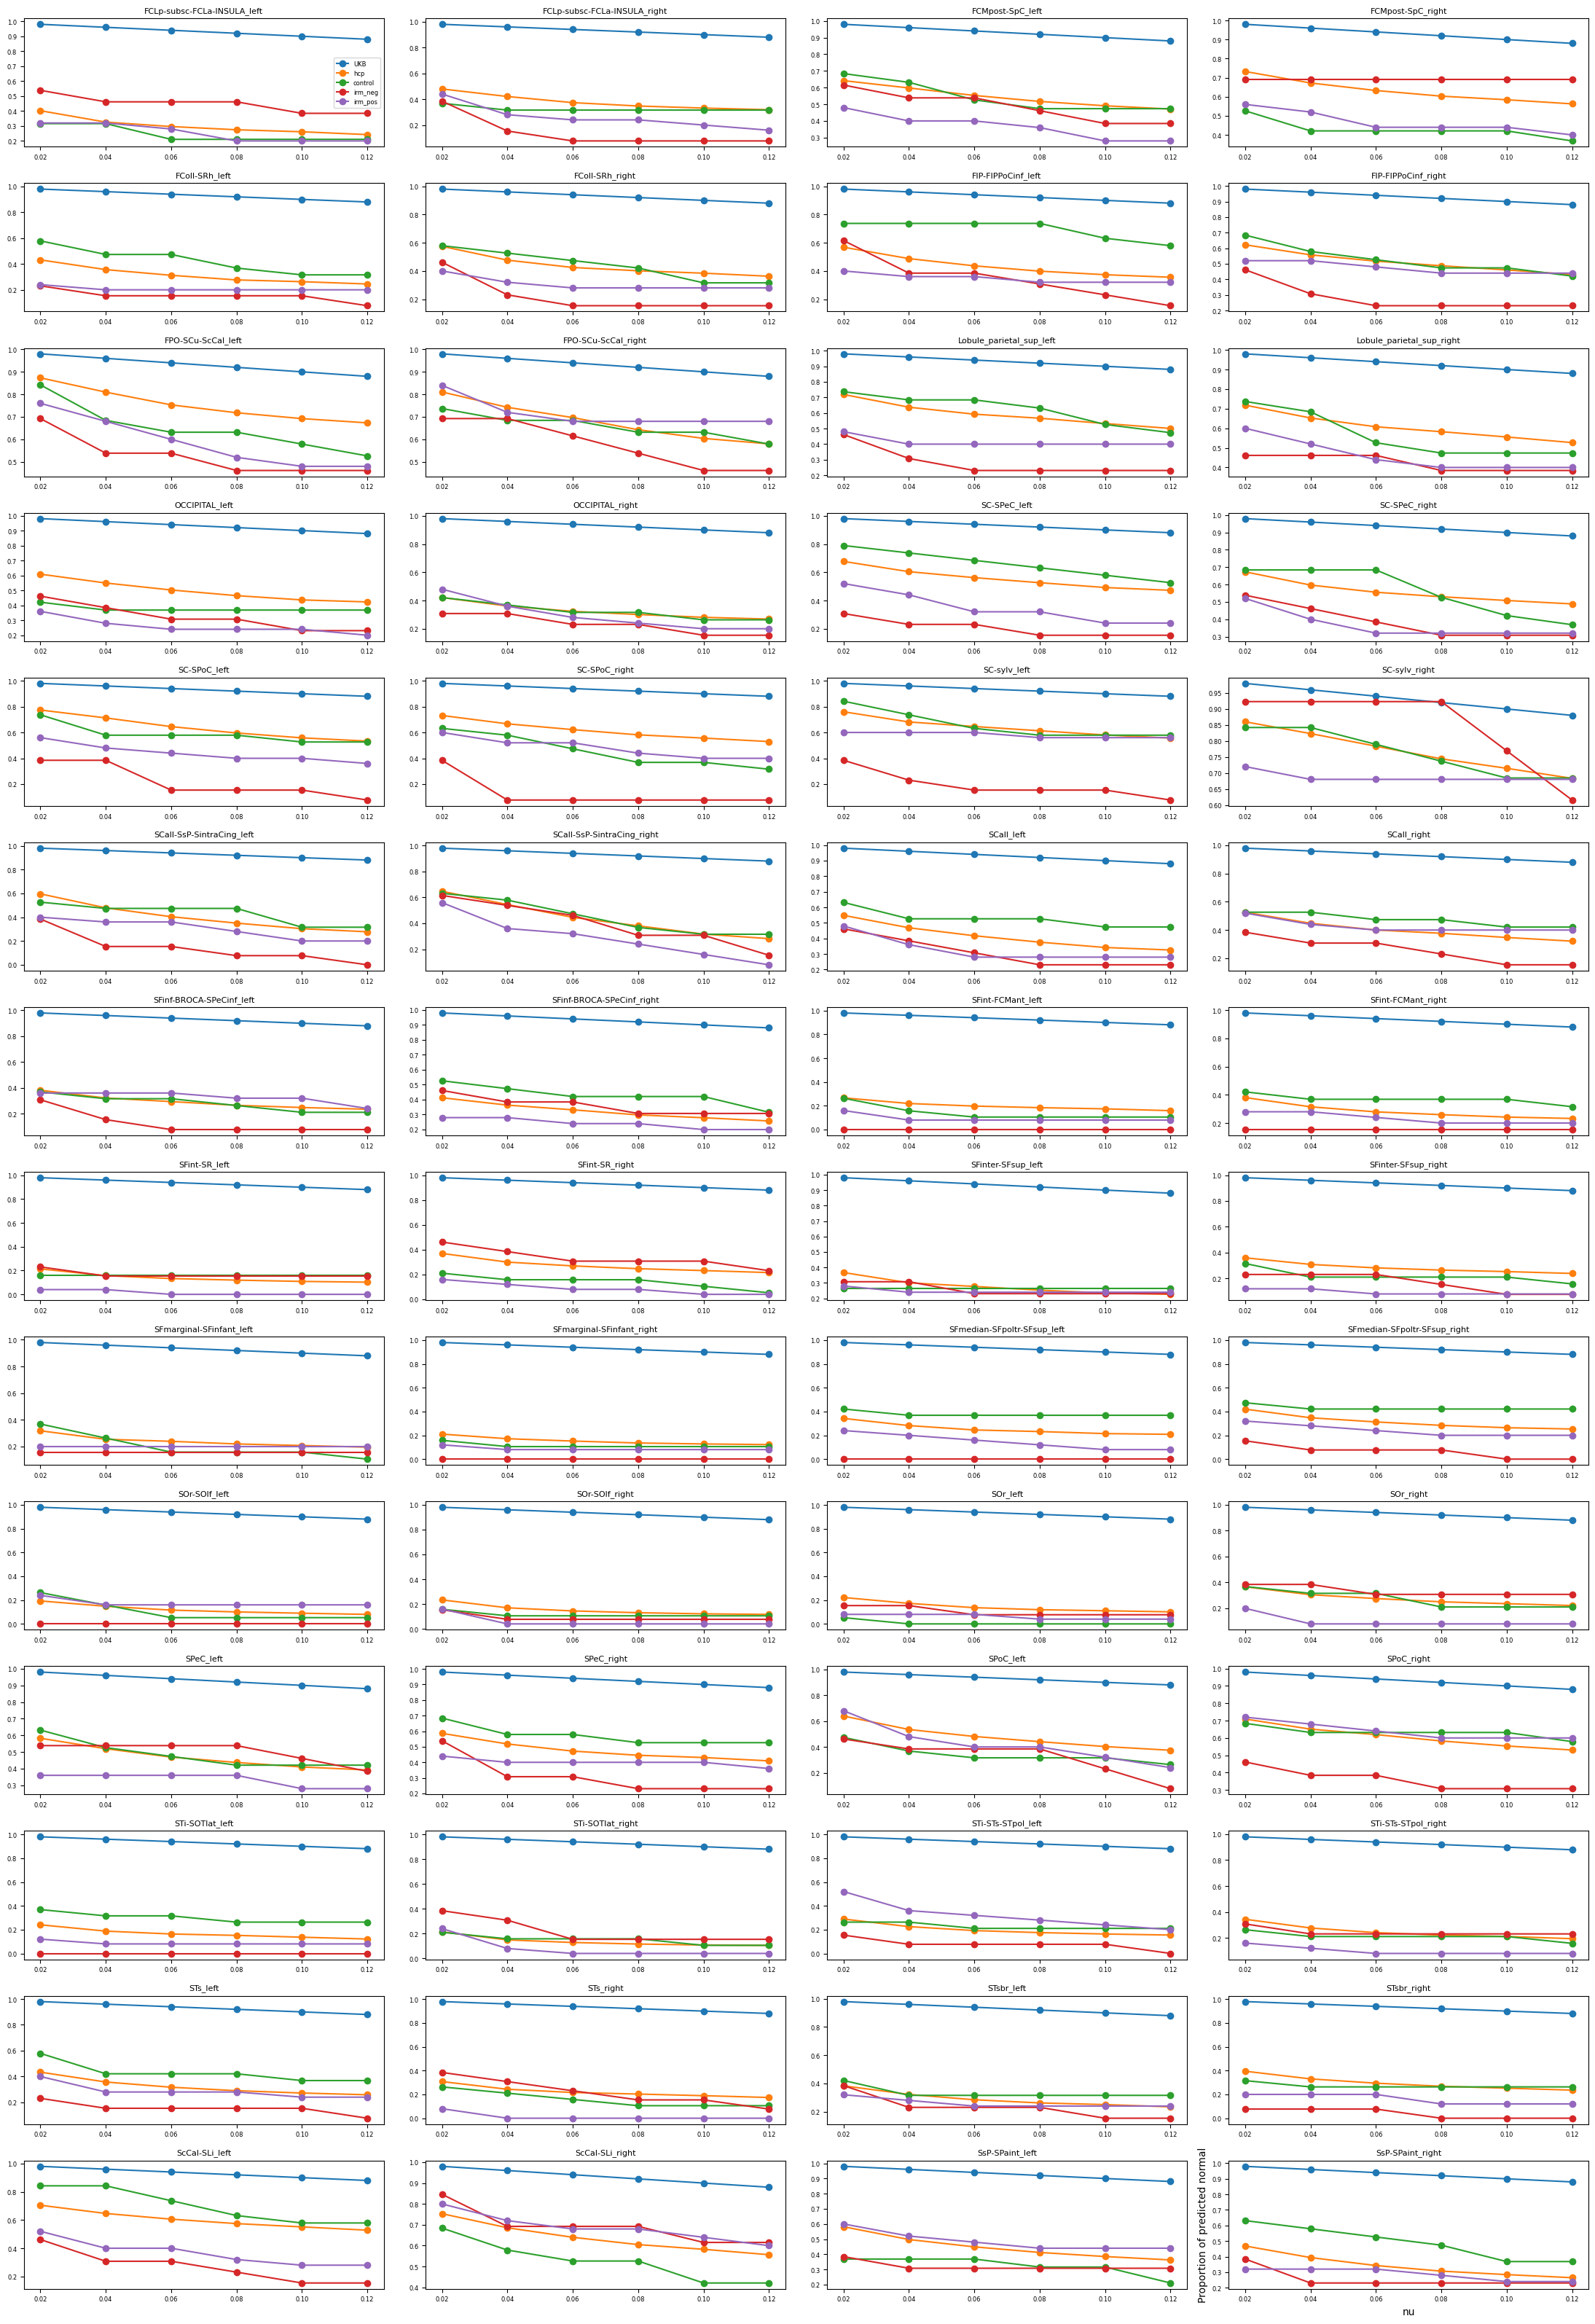

In [30]:

subfolders = sorted([
    f for f in os.listdir(dir_path)
    if os.path.isdir(os.path.join(dir_path, f))
])


rows, cols = 14, 4
total_plots = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(22, 32))
axes = axes.flatten()

nu = np.arange(0.02,0.13,0.02)
for i, folder in enumerate(subfolders):
    print(i)
    regions=re.match(r"(.*?(left|right))", folder).group(1)

    ax = axes[i]
    current_path = os.path.join(dir_path, folder)

    ukb_file = os.path.join(current_path, "Embeddings.csv")
    hcp_file = os.path.join(current_path, "hcp", "Embeddings.csv")
    epi_file = os.path.join(current_path, "epilepsy_PBS", "Embeddings.csv")

    # lecture
    Embeddings_ukb = read_error_csv(ukb_file)
    Embeddings_hcp = read_error_csv(hcp_file)
    Embeddings_epilepsy = read_error_csv(epi_file)

    Embeddings_control, Embeddings_neg, Embeddings_pos= separate_epilepsy_PBS(Embeddings_epilepsy)

    X1= remove_first_column(Embeddings_ukb)
    X2= remove_first_column(Embeddings_hcp)
    X3= remove_first_column(Embeddings_control)
    X4= remove_first_column(Embeddings_neg)
    X5= remove_first_column(Embeddings_pos)

    X1, X2, X3, X4, X5= Normalisation(X1, X2, X3, X4, X5)

    X1, X2, X3, X4, X5 = Residualisation(X1, X2, X3, X4, X5)
    
    X1_umap, X2_umap, X3_umap, X4_umap, X5_umap= UMAP_2D(X1, X2, X3, X4, X5)
    
    prop_positive_UKB, prop_positive_hcp, prop_positive_control, prop_positive_neg, prop_positive_pos= Calcul(nu,X1_umap, X2_umap, X3_umap, X4_umap, X5_umap)

    PLOT(ax, nu, prop_positive_UKB, prop_positive_hcp, prop_positive_control, prop_positive_neg, prop_positive_pos)

    ax.set_title(regions, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    if i == 0:
        ax.legend(fontsize=6)
        plt.xlabel("nu")
        plt.ylabel("Proportion of predicted normal")
        
plt.tight_layout()
plt.show()



In [33]:
nu = 0.02

In [34]:

subfolders = sorted([
    f for f in os.listdir(dir_path)
    if os.path.isdir(os.path.join(dir_path, f))
])



df = pd.DataFrame(columns=["regions", "Proportion of predicted abnormal among patients + proportion of predicted normal among control"])

for i, folder in enumerate(subfolders):
    print(i)
    regions=re.match(r"(.*?(left|right))", folder).group(1)

    current_path = os.path.join(dir_path, folder)

    ukb_file = os.path.join(current_path, "Embeddings.csv")
    hcp_file = os.path.join(current_path, "hcp", "Embeddings.csv")
    epi_file = os.path.join(current_path, "epilepsy_PBS", "Embeddings.csv")

    # lecture
    Embeddings_ukb = read_error_csv(ukb_file)
    Embeddings_hcp = read_error_csv(hcp_file)
    Embeddings_epilepsy = read_error_csv(epi_file)

    Embeddings_control, Embeddings_neg, Embeddings_pos= separate_epilepsy_PBS(Embeddings_epilepsy)

    X1= remove_first_column(Embeddings_ukb)
    X2= remove_first_column(Embeddings_hcp)
    X3= remove_first_column(Embeddings_control)
    X4= remove_first_column(Embeddings_neg)
    X5= remove_first_column(Embeddings_pos)

    X1, X2, X3, X4, X5= Normalisation(X1, X2, X3, X4, X5)
    X1, X2, X3, X4, X5 = Residualisation(X1, X2, X3, X4, X5)

    X_patient= np.concatenate((X4,X5), axis=0)
    reducer = umap.UMAP(n_components=2, random_state=42)
    X1_umap = reducer.fit_transform(X1)
    X3_umap= reducer.transform(X3)
    X_patient_umap = reducer.transform(X_patient)
    
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
    clf.fit(X1_umap)
    y3 = clf.predict(X3_umap)
    y4 = clf.predict(X_patient_umap)

    proportion_normal3=  proportion_positive(y3)
    proportion_abnormal4= 1-  proportion_positive(y4)
    value= proportion_normal3 + proportion_abnormal4

    df.loc[i]=[regions, value]




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [35]:
df= df.sort_values(by="Proportion of predicted abnormal among patients + proportion of predicted normal among control", ascending=False)

In [36]:
df.to_csv("Proportion of predicted abnormal among patients + proportion of predicted normal among control")